# Loan Default Prediction Model - Random Forest (RF)
This notebook aims to predict loan default outcomes based on historical loan data. The approach includes data preprocessing, model training, and evaluation using a Random Forest algorithm.

## Contents

Step 1. Data Loading and Initial Setup

Step 2. Data Preprocessing

Step 3. Feature Engineering

Step 4. Model Training - Random Forest Classifier

Step 5: Feature Importance Analysis

Step 6: Model Evaluation

Step 7: Hyperparameter Tuning

Step 8: Tradeoff Analysis

## Step 1. Data Loading and Initial Setup

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset and set display options
loan = pd.read_csv('../.Database/merged_cleaned_loan.csv')
loan.set_index('id',inplace=True)
pd.set_option('display.max_columns', None)


## Step 2. Data Preprocessing

To prepare our dataset, we will:
1. Drop non-numerical and irrelevant columns.
2. Separate the target variable (loan status) from the features.
3. Identify numerical and categorical features for encoding and scaling.


In [2]:
# As there is only 1 observation with home_ownership = ANY,
# we will drop that observation
loan = loan.drop(loan[loan['home_ownership'] == 'ANY'].index)

# Drop non-numerical and target columns from features
X = loan.drop(columns=['addr_state', 'emp_title', 'loan_status', 'issue_d', 'issue_y', 'issue_m', 'title'])

# Replace 'annual_inc' with its logarithmic version 'log_annual_inc' for normalization purposes
X = X.drop(columns=['annual_inc'])

# Remove outcome-related columns that would otherwise leak information
X = X.drop(columns=['loan_status_grouped', 'grade', 'sub_grade', 'int_rate'])

# Select the target variable for prediction
y = loan['loan_status_grouped']


## Step 3. Feature Engineering

We'll now split the columns into numerical and categorical types. Categorical variables will be one-hot encoded, and numerical variables will be scaled to improve model performance.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define categorical and numerical feature lists
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure alignment of train and test sets to handle any potential dummy variable mismatch
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Scale numerical columns to standardize the data distribution
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

## Step 4. Model Training - Random Forest Classifier

We'll use an Random Forest Classifier to train our model. We'll also use the `RandomForestClassifier` class from the `sklearn.ensemble` module.

In [4]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

rf_model = RandomForestClassifier(
    n_estimators=100,      # number of trees in the forest
    max_depth=6,           # maximum depth of the tree
    min_samples_split=5,   # minimum number of samples required to split an internal node
    min_samples_leaf=2,    # minimum number of samples required to be at a leaf node
    max_features='sqrt',   # number of features to consider when looking for the best split
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

## Step 5. Feature Importance Analysis

We can use the `feature_importances_` attribute of the Random Forest model to get the feature importance values. We can then normalize these values by dividing them by the sum of all feature importances to get the percentage contribution of each feature.

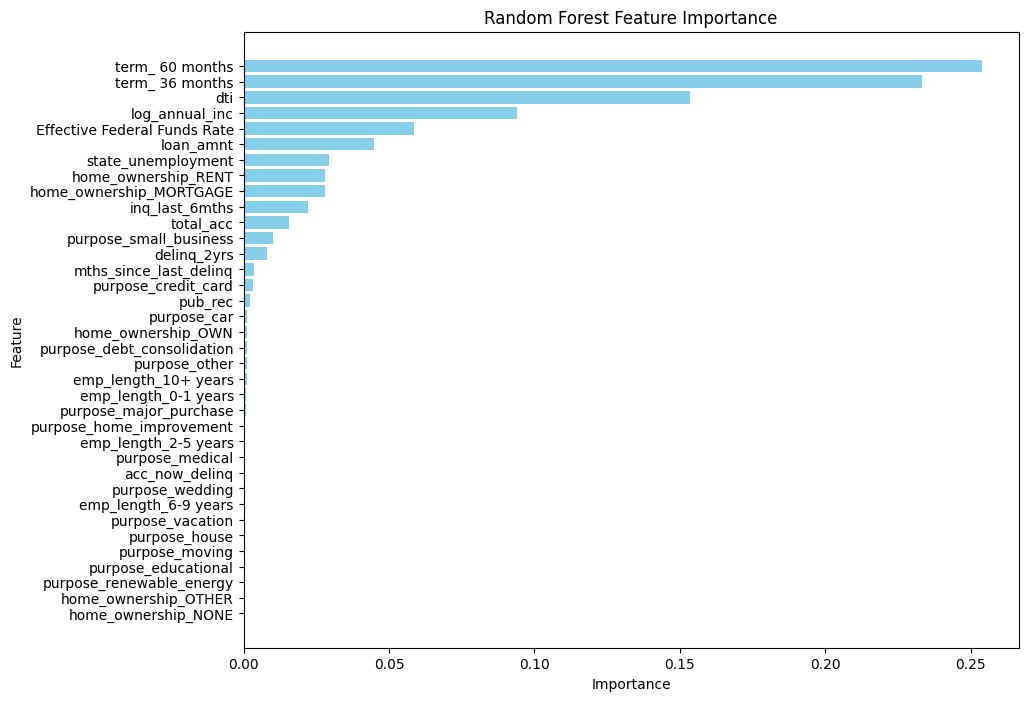

In [5]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Scale importance values by dividing by the total sum to get percentages
total_importance = feature_importances.sum()
percentage_importance = feature_importances / total_importance

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X_train.columns,  # Replace with your feature names if using a DataFrame
    'Importance': percentage_importance
}).sort_values(by='Importance', ascending=True)  # Sorted for better plotting

# Plot feature importances as percentages
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

## Step 6. Model Evaluation

After training, the model is evaluated on the test set. We'll predict classes, generate a classification report, and plot a confusion matrix for performance visualization.


Accuracy: 0.62 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.61      0.71     40423
         1.0       0.31      0.65      0.42     11133

    accuracy                           0.62     51556
   macro avg       0.59      0.63      0.57     51556
weighted avg       0.74      0.62      0.65     51556



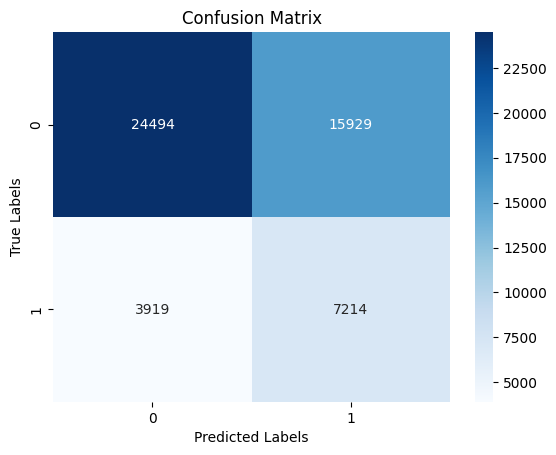

In [6]:
# Predict probabilities
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

threshold = 0.2
y_pred = (y_pred_prob >= threshold).astype(int) 

# Generating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}', "\n")
print("Classification Report:\n", class_report)

# Plotting heatmap for confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Step 7. Hyperparameter Tuning

We'll tune the thresholds for the Random Forest model which will select the best model based on the validation accuracy.

In [7]:
# Define the range of thresholds between 0.2 and 0.3
thresholds = np.arange(0.2, 0.31, 0.01)  # Thresholds from 0.2 to 0.3 in steps of 0.01
confusion_matrices = []
f1_scores = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append((threshold, cm))
    
    # Calculate F1 score for the current threshold
    f1 = f1_score(y_test, y_pred)
    f1_scores.append((threshold, f1))
    
# Identify the threshold with the highest F1 score
best_threshold, best_f1 = max(f1_scores, key=lambda x: x[1])

# Print the confusion matrices and F1 scores for each threshold
for threshold, cm in confusion_matrices:
    print(f"Threshold: {threshold:.2f}\nConfusion Matrix:\n{cm}\n")

print(f"Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.2f}")

Threshold: 0.20
Confusion Matrix:
[[24494 15929]
 [ 3919  7214]]

Threshold: 0.21
Confusion Matrix:
[[26511 13912]
 [ 4490  6643]]

Threshold: 0.22
Confusion Matrix:
[[28083 12340]
 [ 4943  6190]]

Threshold: 0.23
Confusion Matrix:
[[29428 10995]
 [ 5415  5718]]

Threshold: 0.24
Confusion Matrix:
[[30587  9836]
 [ 5816  5317]]

Threshold: 0.25
Confusion Matrix:
[[31593  8830]
 [ 6196  4937]]

Threshold: 0.26
Confusion Matrix:
[[32647  7776]
 [ 6552  4581]]

Threshold: 0.27
Confusion Matrix:
[[33577  6846]
 [ 6919  4214]]

Threshold: 0.28
Confusion Matrix:
[[34408  6015]
 [ 7240  3893]]

Threshold: 0.29
Confusion Matrix:
[[35034  5389]
 [ 7538  3595]]

Threshold: 0.30
Confusion Matrix:
[[35562  4861]
 [ 7803  3330]]

Best Threshold: 0.20 with F1 Score: 0.42


## Step 8. Tradeoff Analysis - TN/FN Ratio and Approved Loans

We can use the following code to calculate the TN/FN ratio and the approved loans.

Maximum TN/FN Ratio: 16.49 at Threshold: 0.12


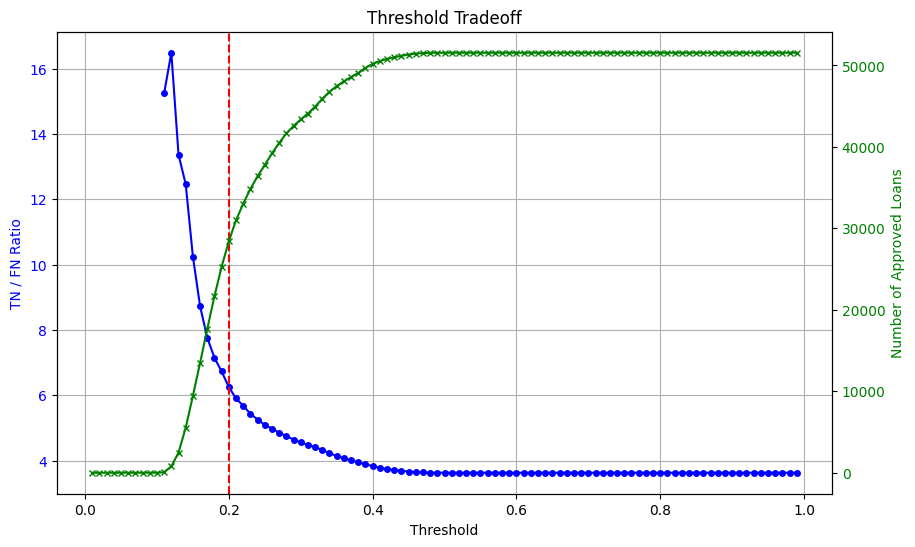

In [8]:
# Plotting True Negatives (TN) / False Negatives (FN) and number of approved loans against the threshold,

y_pred_prob = rf_model.predict_proba(X_test)[:, 1] 

ratios = []
approved_loans = []
thresholds = np.arange(0.01, 1.00, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    TN = np.sum((y_pred == 0) & (y_test.values == 0))
    FN = np.sum((y_pred == 0) & (y_test.values == 1))
    
    if FN > 0:
        ratio = TN / FN
    else:
        ratio = np.nan 

    ratios.append(ratio)
    approved_loans.append(TN + FN)

# Filter out infinite and NaN ratios
valid_ratios = [(ratio, threshold) for ratio, threshold in zip(ratios, thresholds) if pd.notna(ratio) and ratio != np.inf]

# Find the maximum ratio and its corresponding threshold
if valid_ratios:
    max_ratio, best_threshold = max(valid_ratios, key=lambda x: x[0])

    # Print the threshold that gives the maximum ratio
    print(f'Maximum TN/FN Ratio: {max_ratio:.2f} at Threshold: {best_threshold:.2f}')
else:
    print("No valid ratios found.")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the TN/FN ratio on the primary y-axis
ax1.plot(thresholds, ratios, marker='o', markersize=4, color='b', label='TN / FN Ratio')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('TN / FN Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid()

# Create a secondary y-axis to plot the number of approved loans
ax2 = ax1.twinx()
ax2.plot(thresholds, approved_loans, marker='x', markersize=4, color='g', label='Number of Approved Loans')
ax2.set_ylabel('Number of Approved Loans', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Set limits for the y-axes
try:
    max_ratio_limit = max(filter(lambda x: x != np.inf, ratios), default=0)
    ax1.set_ylim(0, max_ratio_limit * 1.1)

    max_approved_loans_limit = max(approved_loans, default=0)
    ax2.set_ylim(0, max_approved_loans_limit * 1.1)
except ValueError:
    pass

# Plotting a vertical line at threshold = 0.2
ax1.axvline(x=0.2, color='r', linestyle='--', label='Threshold = 0.2')

plt.title('Threshold Tradeoff')

plt.show()


In [9]:
# Export results
rf_results = pd.DataFrame({
    "Threshold": thresholds,
    "Ratio": ratios,
    "Approved Loan": approved_loans
})

# Export to CSV
rf_results.to_csv("../.systemfiles/rf_results.csv", index=False)